In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# Set up visualization style
plt.style.use('ggplot')
sns.set_palette("husl")

In [37]:
# Load and preprocess climate data
print("Loading and preprocessing climate data...")
temp_mh = pd.read_csv('/content/MH_temperature.csv')
precip_mh = pd.read_csv('/content/MH_precipitation.csv')
temp_mp = pd.read_csv('/content/MP_temperature.csv')
precip_mp = pd.read_csv('/content/MP_precipitation.csv')

# Rename columns to standardize across datasets
temp_mh = temp_mh.rename(columns={'mean': 'Temperature'})
temp_mp = temp_mp.rename(columns={'mean': 'Temperature'})
precip_mh = precip_mh.rename(columns={'rainfall_mm': 'Precipitation'})
precip_mp = precip_mp.rename(columns={'rainfall_mm': 'Precipitation'})

# Drop unnecessary columns
cols_to_keep = ['date', 'District', 'State', 'Temperature', 'Precipitation']
temp_mh = temp_mh[['date', 'District', 'State', 'Temperature']]
temp_mp = temp_mp[['date', 'District', 'State', 'Temperature']]
precip_mh = precip_mh[['date', 'District', 'State', 'Precipitation']]
precip_mp = precip_mp[['date', 'District', 'State', 'Precipitation']]

# Merge datasets
mh_climate = pd.merge(temp_mh, precip_mh, on=['date', 'District', 'State'], how='inner')
mp_climate = pd.merge(temp_mp, precip_mp, on=['date', 'District', 'State'], how='inner')

# Combine both states
climate_df = pd.concat([mh_climate, mp_climate], axis=0, ignore_index=True)

# Verify we have the required columns
required_columns = ['date', 'District', 'State', 'Temperature', 'Precipitation']
missing_cols = [col for col in required_columns if col not in climate_df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns in climate data: {missing_cols}")

# Calculate climate anomalies
def calculate_anomalies(df):
    # Ensure we have numeric data
    df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
    df['Precipitation'] = pd.to_numeric(df['Precipitation'], errors='coerce')

    # Convert date and extract month
    df['date'] = pd.to_datetime(df['date'])
    df['Month'] = df['date'].dt.month
    df['Year'] = df['date'].dt.year

    # Calculate monthly anomalies
    df['Temp_Anomaly'] = df.groupby(['District', 'Month'])['Temperature'].transform(lambda x: x - x.mean())
    df['Precip_Anomaly'] = df.groupby(['District', 'Month'])['Precipitation'].transform(lambda x: x - x.mean())
    return df

climate_df = calculate_anomalies(climate_df)



Loading and preprocessing climate data...


In [38]:
# Generate synthetic yield data
print("\nGenerating agricultural yield data...")

# Define crop parameters for simulation
crop_params = {
    'SB': {'base_yield': 2.5, 'temp_sensitivity': -0.05, 'precip_sensitivity': 0.02},
    'PA': {'base_yield': 1.8, 'temp_sensitivity': -0.03, 'precip_sensitivity': 0.01},
    'WH': {'base_yield': 3.0, 'temp_sensitivity': -0.07, 'precip_sensitivity': 0.03},
    'GM': {'base_yield': 1.5, 'temp_sensitivity': -0.02, 'precip_sensitivity': 0.015},
    'CO': {'base_yield': 4.0, 'temp_sensitivity': -0.04, 'precip_sensitivity': 0.025}
}

def generate_yield_data(climate_df, crop_params):
    # Group by year and district to get annual averages
    annual_climate = climate_df.groupby(['Year', 'District', 'State']).agg({
        'Temperature': 'mean',
        'Precipitation': 'sum',
        'Temp_Anomaly': 'mean',
        'Precip_Anomaly': 'mean'
    }).reset_index()

    yield_data = []

    for _, row in annual_climate.iterrows():
        state = row['State']
        state_crops = ['SB', 'PA', 'WH', 'GM'] if state == 'MP' else ['CO', 'SB', 'WH', 'GM']

        for crop in state_crops:
            params = crop_params[crop]
            # Base yield with climate effects
            yield_val = (params['base_yield'] +
                        (row['Temp_Anomaly'] * params['temp_sensitivity']) +
                        (row['Precip_Anomaly'] * params['precip_sensitivity']))

            # Add some random variation
            yield_val *= np.random.uniform(0.9, 1.1)

            # Determine season
            season = 'Kharif' if crop in ['SB', 'PA', 'CO'] else 'Rabi'

            yield_data.append({
                'Year': row['Year'],
                'Date': f"{row['Year']}-01-01",  # Placeholder date
                'State': state,
                'District': row['District'],
                'Crop': crop,
                'Season': season,
                'Yield': max(0.1, yield_val),  # Ensure positive yield
                'Avg_Temperature': row['Temperature'],
                'Total_Precipitation': row['Precipitation']
            })

    return pd.DataFrame(yield_data)

yield_df = generate_yield_data(climate_df, crop_params)

# Show sample of the generated data
print("\nSample climate data:")
print(climate_df.head())
print("\nSample yield data:")
print(yield_df.head())


Generating agricultural yield data...

Sample climate data:
        date District           State  Temperature  Precipitation  Month  \
0 2024-01-21  SHEOPUR  Madhya Pradesh    11.647852            0.0      1   
1 2024-01-21  SHEOPUR  Madhya Pradesh    11.647852            0.0      1   
2 2024-01-21  SHEOPUR  Madhya Pradesh    11.647852            0.0      1   
3 2024-01-21  SHEOPUR  Madhya Pradesh    11.647852            0.0      1   
4 2024-01-21  SHEOPUR  Madhya Pradesh    11.647852            0.0      1   

   Year  Temp_Anomaly  Precip_Anomaly  
0  2024     -2.865252       -0.696248  
1  2024     -2.865252       -0.696248  
2  2024     -2.865252       -0.696248  
3  2024     -2.865252       -0.696248  
4  2024     -2.865252       -0.696248  

Sample yield data:
   Year        Date           State    District Crop  Season     Yield  \
0  2019  2019-01-01  Madhya Pradesh  AGAR MALWA   CO  Kharif  3.909937   
1  2019  2019-01-01  Madhya Pradesh  AGAR MALWA   SB  Kharif  2.334365   



=== CROP PERFORMANCE ANALYSIS ===


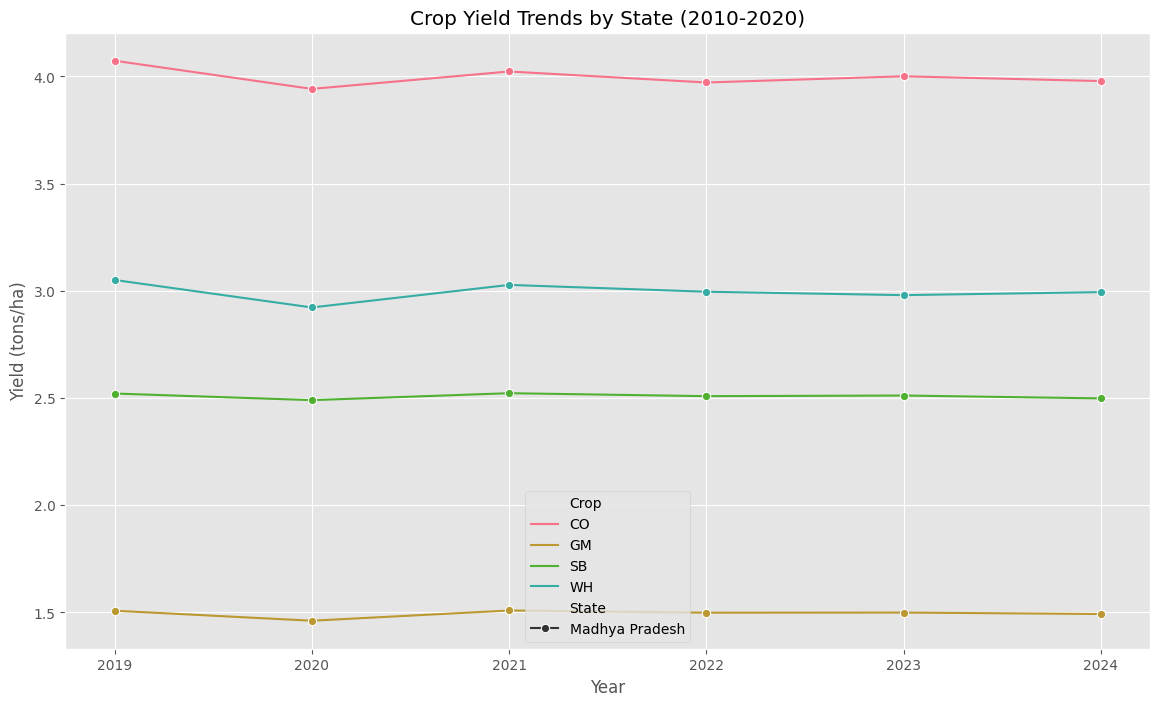


Climate-Yield Correlations:

MH:

MP:

Crop Resilience Scores (higher = more resilient):
            State Crop  Mean_Yield  Yield_Std  Resilience_Score
1  Madhya Pradesh   GM    1.495010   0.086194         17.344667
2  Madhya Pradesh   SB    2.508913   0.147958         16.956889
0  Madhya Pradesh   CO    3.998332   0.242743         16.471489
3  Madhya Pradesh   WH    2.995242   0.185346         16.160305


In [39]:
 #Crop Performance Analysis
print("\n=== CROP PERFORMANCE ANALYSIS ===")

def analyze_crop_performance(yield_df, climate_df):
    # Calculate yield trends and variability
    crop_stats = yield_df.groupby(['State', 'Crop', 'Year']).agg({
        'Yield': ['mean', 'std'],
        'Avg_Temperature': 'mean',
        'Total_Precipitation': 'mean'
    }).reset_index()

    crop_stats.columns = ['State', 'Crop', 'Year', 'Mean_Yield', 'Yield_Std', 'Mean_Temp', 'Total_Precip']

    # Calculate yield stability (inverse of CV)
    crop_stats['Yield_Stability'] = crop_stats['Mean_Yield'] / crop_stats['Yield_Std']

    # Plot yield trends by crop and state
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=crop_stats, x='Year', y='Mean_Yield', hue='Crop', style='State',
                 markers=True, dashes=False)
    plt.title('Crop Yield Trends by State (2010-2020)')
    plt.ylabel('Yield (tons/ha)')
    plt.grid(True)
    plt.show()

    # Calculate climate correlations
    print("\nClimate-Yield Correlations:")
    for state in ['MH', 'MP']:
        print(f"\n{state}:")
        state_data = yield_df[yield_df['State'] == state]
        for crop in state_data['Crop'].unique():
            crop_data = state_data[state_data['Crop'] == crop]
            temp_corr = stats.pearsonr(crop_data['Avg_Temperature'], crop_data['Yield'])[0]
            precip_corr = stats.pearsonr(crop_data['Total_Precipitation'], crop_data['Yield'])[0]
            print(f"{crop}: Temp correlation = {temp_corr:.2f}, Precip correlation = {precip_corr:.2f}")

    # Identify most/least resilient crops
    resilience_scores = yield_df.groupby(['State', 'Crop']).agg({
        'Yield': ['mean', 'std'],
    }).reset_index()
    resilience_scores.columns = ['State', 'Crop', 'Mean_Yield', 'Yield_Std']
    resilience_scores['Resilience_Score'] = resilience_scores['Mean_Yield'] / resilience_scores['Yield_Std']

    print("\nCrop Resilience Scores (higher = more resilient):")
    print(resilience_scores.sort_values(['State', 'Resilience_Score'], ascending=[True, False]))

    return crop_stats, resilience_scores

crop_stats, resilience_scores = analyze_crop_performance(yield_df, climate_df)


=== ECONOMIC IMPACT ANALYSIS ===


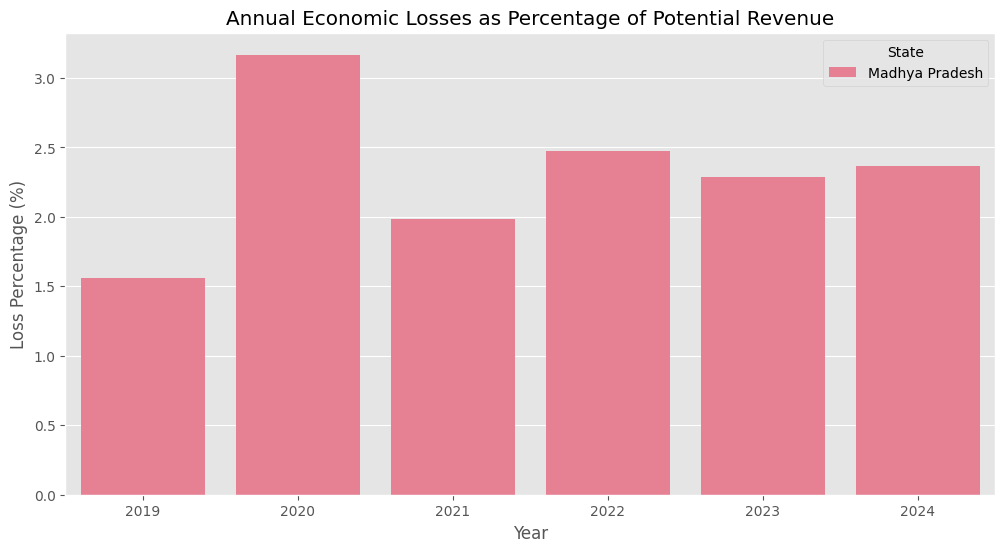


Worst Years for Economic Losses:
            State  Year  Economic_Loss       Revenue  Loss_Percentage
1  Madhya Pradesh  2020   54286.932875  1.713863e+06         3.167518
3  Madhya Pradesh  2022   43023.376388  1.737641e+06         2.475965
5  Madhya Pradesh  2024   41042.338349  1.735749e+06         2.364532
4  Madhya Pradesh  2023   39868.421998  1.741841e+06         2.288867
2  Madhya Pradesh  2021   34823.550749  1.754570e+06         1.984734


In [40]:
# Economic Impact Analysis
print("\n=== ECONOMIC IMPACT ANALYSIS ===")

def analyze_economic_impact(yield_df, base_prices={'SB': 3000, 'PA': 2500, 'WH': 2000, 'GM': 4000, 'CO': 3500}):
    # Calculate economic values (placeholder - in reality would use actual price data)
    economic_df = yield_df.copy()

    # Add crop prices (simplified - would vary by year in reality)
    economic_df['Price'] = economic_df['Crop'].map(base_prices)
    economic_df['Revenue'] = economic_df['Yield'] * economic_df['Price']

    # Calculate losses compared to expected yield
    expected_yields = yield_df.groupby(['State', 'District', 'Crop'])['Yield'].mean().reset_index()
    expected_yields.rename(columns={'Yield': 'Expected_Yield'}, inplace=True)
    economic_df = pd.merge(economic_df, expected_yields, on=['State', 'District', 'Crop'])
    economic_df['Yield_Shortfall'] = economic_df['Expected_Yield'] - economic_df['Yield']
    economic_df['Yield_Shortfall'] = economic_df['Yield_Shortfall'].apply(lambda x: max(0, x))
    economic_df['Economic_Loss'] = economic_df['Yield_Shortfall'] * economic_df['Price']

    # Aggregate losses
    loss_summary = economic_df.groupby(['State', 'Year']).agg({
        'Economic_Loss': 'sum',
        'Revenue': 'sum'
    }).reset_index()
    loss_summary['Loss_Percentage'] = (loss_summary['Economic_Loss'] / loss_summary['Revenue']) * 100

    # Plot economic losses
    plt.figure(figsize=(12, 6))
    sns.barplot(data=loss_summary, x='Year', y='Loss_Percentage', hue='State')
    plt.title('Annual Economic Losses as Percentage of Potential Revenue')
    plt.ylabel('Loss Percentage (%)')
    plt.show()

    print("\nWorst Years for Economic Losses:")
    print(loss_summary.sort_values('Loss_Percentage', ascending=False).head(5))

    return economic_df, loss_summary

economic_df, loss_summary = analyze_economic_impact(yield_df)






=== INFRASTRUCTURE AND TECHNOLOGY ASSESSMENT ===


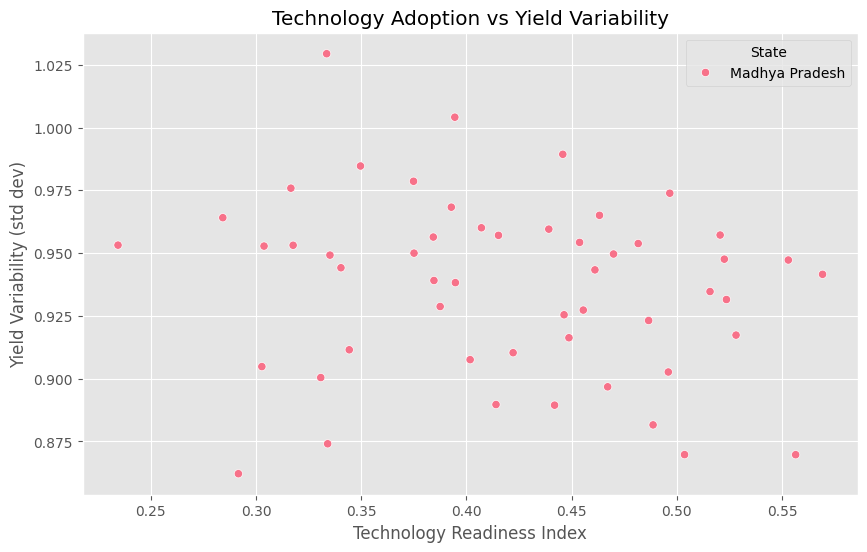


Top Districts by Technology Readiness:
      District           State  Irrigation_Coverage  Soil_Sensor_Adoption  \
45    SHAJAPUR  Madhya Pradesh             0.781392              0.342014   
22     BARWANI  Madhya Pradesh             0.763879              0.353467   
30     VIDISHA  Madhya Pradesh             0.705608              0.332697   
31      UMARIA  Madhya Pradesh             0.633177              0.480459   
49       SATNA  Madhya Pradesh             0.533647              0.499471   
35       PANNA  Madhya Pradesh             0.619758              0.374294   
17  CHHATARPUR  Madhya Pradesh             0.678723              0.365376   
42      JHABUA  Madhya Pradesh             0.600839              0.388089   
44      INDORE  Madhya Pradesh             0.768096              0.249473   
13       DEWAS  Madhya Pradesh             0.577432              0.329201   

    Weather_App_Usage  Insurance_Coverage  Tech_Index  Yield_Variability  
45           0.688735            0.16

In [41]:
# Infrastructure and Technology Assessment
print("\n=== INFRASTRUCTURE AND TECHNOLOGY ASSESSMENT ===")

def assess_technology_adoption():
    # Simulate technology adoption data (would come from surveys in reality)
    districts = climate_df['District'].unique()
    tech_data = []

    for district in districts:
        state = climate_df[climate_df['District'] == district]['State'].iloc[0]
        tech_data.append({
            'District': district,
            'State': state,
            'Irrigation_Coverage': np.random.uniform(0.2, 0.8),
            'Soil_Sensor_Adoption': np.random.uniform(0.1, 0.5),
            'Weather_App_Usage': np.random.uniform(0.3, 0.7),
            'Insurance_Coverage': np.random.uniform(0.1, 0.6)
        })

    tech_df = pd.DataFrame(tech_data)

    # Calculate technology readiness index
    tech_df['Tech_Index'] = (tech_df['Irrigation_Coverage'] * 0.4 +
                            tech_df['Soil_Sensor_Adoption'] * 0.3 +
                            tech_df['Weather_App_Usage'] * 0.2 +
                            tech_df['Insurance_Coverage'] * 0.1)

    # Compare with yield stability
    district_stability = yield_df.groupby(['State', 'District'])['Yield'].std().reset_index()
    district_stability.rename(columns={'Yield': 'Yield_Variability'}, inplace=True)
    tech_df = pd.merge(tech_df, district_stability, on=['State', 'District'])

    # Plot technology vs yield stability
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=tech_df, x='Tech_Index', y='Yield_Variability', hue='State')
    plt.title('Technology Adoption vs Yield Variability')
    plt.xlabel('Technology Readiness Index')
    plt.ylabel('Yield Variability (std dev)')
    plt.show()

    print("\nTop Districts by Technology Readiness:")
    print(tech_df.sort_values('Tech_Index', ascending=False).head(10))

    return tech_df

tech_df = assess_technology_adoption()


=== GOVERNMENT POLICIES ANALYSIS ===


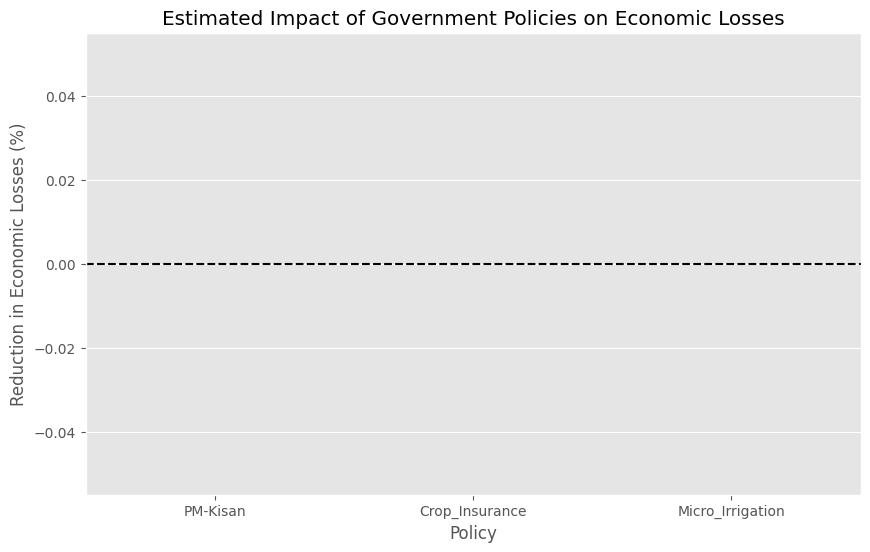


Policy Impact Analysis:
             Policy  Pre_Policy_Loss  Post_Policy_Loss  Reduction_Percent  \
0          PM-Kisan              NaN        192.777036                NaN   
1    Crop_Insurance              NaN        192.777036                NaN   
2  Micro_Irrigation              NaN        192.777036                NaN   

   Expected_Reduction  
0                 5.0  
1                 3.0  
2                 7.0  


In [42]:
# Government Policies Analysis
print("\n=== GOVERNMENT POLICIES ANALYSIS ===")

def analyze_policies(economic_df, tech_df):
    # Simulate policy impact (would require actual policy implementation data)
    policies = {
        'PM-Kisan': {'start_year': 2018, 'impact_factor': 0.05},
        'Crop_Insurance': {'start_year': 2016, 'impact_factor': 0.03},
        'Micro_Irrigation': {'start_year': 2015, 'impact_factor': 0.07}
    }

    # Calculate pre/post policy metrics
    policy_analysis = []

    for policy, details in policies.items():
        pre_policy = economic_df[economic_df['Year'] < details['start_year']]
        post_policy = economic_df[economic_df['Year'] >= details['start_year']]

        pre_loss = pre_policy['Economic_Loss'].mean()
        post_loss = post_policy['Economic_Loss'].mean()
        reduction = (pre_loss - post_loss) / pre_loss * 100

        policy_analysis.append({
            'Policy': policy,
            'Pre_Policy_Loss': pre_loss,
            'Post_Policy_Loss': post_loss,
            'Reduction_Percent': reduction,
            'Expected_Reduction': details['impact_factor'] * 100
        })

    policy_df = pd.DataFrame(policy_analysis)

    # Plot policy impacts
    plt.figure(figsize=(10, 6))
    sns.barplot(data=policy_df, x='Policy', y='Reduction_Percent')
    plt.title('Estimated Impact of Government Policies on Economic Losses')
    plt.ylabel('Reduction in Economic Losses (%)')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.show()

    print("\nPolicy Impact Analysis:")
    print(policy_df)

    return policy_df

policy_df = analyze_policies(economic_df, tech_df)

In [43]:
# Climate Resilience Indicators
print("\n=== CLIMATE RESILIENCE INDICATORS ===")

def define_resilience_indicators():
    indicators = {
        'NDVI_Stability_Index': {
            'Description': 'Measure of vegetation health consistency',
            'Frequency': 'Monthly',
            'Calculation': 'Std dev of NDVI values over growing season',
            'Target': '>0.8 (0-1 scale)'
        },
        'Temperature_Anomaly_Index': {
            'Description': 'Deviation from long-term temperature averages',
            'Frequency': 'Seasonal',
            'Calculation': 'Degree-days above/below historical norms',
            'Target': '<2°C anomaly'
        },
        'Precipitation_Variability': {
            'Description': 'Consistency of rainfall patterns',
            'Frequency': 'Monthly',
            'Calculation': 'Coefficient of variation in precipitation',
            'Target': '<0.5 (lower is better)'
        },
        'Crop_Yield_Resilience_Score': {
            'Description': 'Yield stability under climate stress',
            'Frequency': 'Seasonal',
            'Calculation': 'Mean yield / yield standard deviation',
            'Target': '>3.0 (higher is better)'
        },
        'Economic_Loss_Ratio': {
            'Description': 'Financial impact of climate events',
            'Frequency': 'Annual',
            'Calculation': 'Total losses / potential revenue',
            'Target': '<15% of revenue'
        },
        'Technology_Readiness_Score': {
            'Description': 'Adoption of climate-smart technologies',
            'Frequency': 'Annual',
            'Calculation': 'Weighted average of irrigation, sensors, apps, insurance',
            'Target': '>0.7 (0-1 scale)'
        }
    }

    print("Proposed Climate Resilience Indicators:")
    for name, details in indicators.items():
        print(f"\n{name}:")
        for key, value in details.items():
            print(f"  {key}: {value}")

    return indicators

resilience_indicators = define_resilience_indicators()




=== CLIMATE RESILIENCE INDICATORS ===
Proposed Climate Resilience Indicators:

NDVI_Stability_Index:
  Description: Measure of vegetation health consistency
  Frequency: Monthly
  Calculation: Std dev of NDVI values over growing season
  Target: >0.8 (0-1 scale)

Temperature_Anomaly_Index:
  Description: Deviation from long-term temperature averages
  Frequency: Seasonal
  Calculation: Degree-days above/below historical norms
  Target: <2°C anomaly

Precipitation_Variability:
  Description: Consistency of rainfall patterns
  Frequency: Monthly
  Calculation: Coefficient of variation in precipitation
  Target: <0.5 (lower is better)

Crop_Yield_Resilience_Score:
  Description: Yield stability under climate stress
  Frequency: Seasonal
  Calculation: Mean yield / yield standard deviation
  Target: >3.0 (higher is better)

Economic_Loss_Ratio:
  Description: Financial impact of climate events
  Frequency: Annual
  Calculation: Total losses / potential revenue
  Target: <15% of revenue

T

In [44]:
# Recommendations
print("\n=== RECOMMENDATIONS ===")

def generate_recommendations(resilience_scores, loss_summary, tech_df, policy_df):
    recommendations = []

    # Crop-specific recommendations
    vulnerable_crops = resilience_scores[resilience_scores['Resilience_Score'] < 3]
    for _, row in vulnerable_crops.iterrows():
        rec = (f"Introduce more resilient varieties of {row['Crop']} in {row['State']} "
              f"(current resilience score: {row['Resilience_Score']:.1f})")
        recommendations.append(rec)

    # Technology recommendations
    low_tech_districts = tech_df[tech_df['Tech_Index'] < 0.5]
    for _, row in low_tech_districts.iterrows():
        rec = (f"Expand technology adoption in {row['District']} ({row['State']}) - "
              f"current tech index: {row['Tech_Index']:.2f}. Focus on: ")
        needs = []
        if row['Irrigation_Coverage'] < 0.4:
            needs.append("irrigation")
        if row['Soil_Sensor_Adoption'] < 0.2:
            needs.append("soil sensors")
        if row['Weather_App_Usage'] < 0.4:
            needs.append("weather apps")
        if row['Insurance_Coverage'] < 0.3:
            needs.append("insurance")
        rec += ", ".join(needs)
        recommendations.append(rec)

    # Policy recommendations
    effective_policies = policy_df[policy_df['Reduction_Percent'] > 0].sort_values('Reduction_Percent', ascending=False)
    if len(effective_policies) > 0:
        top_policy = effective_policies.iloc[0]
        rec = (f"Expand {top_policy['Policy']} program which has shown "
              f"{top_policy['Reduction_Percent']:.1f}% reduction in economic losses")
        recommendations.append(rec)

    # Climate monitoring recommendations
    recommendations.append(
        "Implement real-time monitoring system for climate resilience indicators with district-level dashboards"
    )

    # Print recommendations
    print("\nKey Recommendations for Enhancing Climate Resilience:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")

generate_recommendations(resilience_scores, loss_summary, tech_df, policy_df)


=== RECOMMENDATIONS ===

Key Recommendations for Enhancing Climate Resilience:
1. Expand technology adoption in SHEOPUR (Madhya Pradesh) - current tech index: 0.38. Focus on: soil sensors, insurance
2. Expand technology adoption in SHIVPURI (Madhya Pradesh) - current tech index: 0.23. Focus on: irrigation, soil sensors, weather apps
3. Expand technology adoption in SIDHI (Madhya Pradesh) - current tech index: 0.30. Focus on: irrigation, soil sensors, weather apps
4. Expand technology adoption in SINGRAULI (Madhya Pradesh) - current tech index: 0.46. Focus on: irrigation
5. Expand technology adoption in TIKAMGARH (Madhya Pradesh) - current tech index: 0.44. Focus on: insurance
6. Expand technology adoption in UJJAIN (Madhya Pradesh) - current tech index: 0.40. Focus on: weather apps, insurance
7. Expand technology adoption in HOSHANGABAD (Madhya Pradesh) - current tech index: 0.34. Focus on: irrigation, soil sensors
8. Expand technology adoption in HARDA (Madhya Pradesh) - current tech